In [2]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import telegram
import pandahouse
from datetime import date, timedelta, datetime
import io
from read_db.CH import Getch
import sys
import os

import time
from tqdm import tqdm


sns.set()

Моделируем ситуацию, когда необходимо сделать систему алертинга в онлайн режиме, поэтому в работе будем использовать простые стат модели, которым в реалтайм режиме работают быстрее и более удобны в применении при таком режиме

Прежде чем выставлять окончательные параметры модели на прод, надо их подобрать по историческим данным. К каждой метрике нужно подобрать модель, по которой будет детектироваться подходящие аномалии, а также параметры этой модели. В расчетах будем использовать детекцию аномалий либо через zscore, либо через iqr. 


Алгоритм подбора параметров:
    
    - Какждая модель принимает на вход значения за текущий день до текущего момента. После этого скользящим окном (размеры окна передаются через аргументы) считает необходимые метрики и на основе этих метрик принимает результат: аномалия или нет. Под каждую модель заведена отдельная функция, которая на выходе выдает стандартный результат: рассчитанные метрики и индексы аномальных данных, которые пометила модель.
    
    - Чтобы мы могли контролировать процесс подбора параметров, в данные самостоятельно добавляются случайным образом аномалии. Количество аномалий, которые надо добавить, размер аномалии (lift), а также порог, после которого мы будем считать lift аномалией - передается через аргументы в функции добавления аномалий. Порог (anomalies_border) тут добавлен специально, чтобы иметь возмодность обучать модель на аномалиях, которые для нас условно приемлемы и на которых мы бы хотели, чтобы модель не реагировала. Только аномалии, которые получились больше этого порога, будут помечены как истинные аномалии, которые мы хотим задетектить моделью.
    
    - Чтобы иметь возможность принимать решение об оптимальных параметрах модели, был организован подсчет false positive rates, false negatives rates, true positives rates и true negatives rates. Процесс был организован в цикле, где на каждый цикл приходилось n итерации и определенное значение параметра.
    
    

In [3]:
def iqr_outlier(src, window, **kwargs):
    
    __iqr_outlier__ = 'iqr'
    
    metric=kwargs['metric']
    alpha=kwargs['alpha']
    rl = src.rolling(f'{window * 15}min', closed='left', min_periods=3).agg([lambda x: x.quantile(.25), lambda x: x.quantile(.75)]).reset_index()
    rl.columns = rl.columns.droplevel(0)
    rl.columns = ['ts','perc_25', 'perc_75']
    rl['iqr'] = rl.perc_75 - rl.perc_25
    rl['low_border'] = rl.perc_25 - alpha * rl.iqr
    rl['high_border'] = rl.perc_25 + alpha * rl.iqr
    rl.set_index('ts', inplace=True)
    return rl[['low_border', 'high_border']], src[(src[metric] > rl.high_border) | (src[metric] < rl.low_border)].index
    


In [4]:
def zscore(src, window, **kwargs):
    
    __name__ = 'zscore'
    
    metric=kwargs['metric']
    d = src.rolling(f'{window * 15}min', closed='left', min_periods=window)
    avg = d.mean()
    dev = d.std(ddof=1)
    z = (src - avg) / dev
    res = z[metric]
    return res, res[abs(res) > 3].index

In [5]:
def plot_results_with_alerts(df_union, alert_data, all_trained_data, metric, model_name=''):
    sns.set(rc={'figure.figsize': (25, 5)}); # задаем размер графика

    fig, axes = plt.subplots(1, 2)

    ax = sns.lineplot( # строим линейный график
        data=df_union.sort_values(by=['date', 'hm']), # задаем датафрейм для графика
        x="hm", y=metric, # указываем названия колонок в датафрейме для x и y
        hue="date", # задаем "группировку" на графике, т е хотим чтобы для каждого значения date была своя линия построена
        ax = axes[0]);

    for x in alert_data:

        axes[0].axvline(x.strftime('%H:%M'), 0, math.ceil(max(df_union[metric])), alpha=1, c='r', linestyle=':', linewidth=1.9);

    for ind, label in enumerate(axes[0].get_xticklabels()): # этот цикл нужен чтобы разрядить подписи координат по оси Х,
        if ind % 3 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)
            
    axes[0].set(xlabel='time') # задаем имя оси Х
    axes[0].set(ylabel=metric) # задаем имя оси У

    axes[0].set_title('{}'.format(metric)) # задае заголовок графика
    axes[0].set(ylim=(0, None)) # задаем лимит для оси У
    axes[0].tick_params(axis='x', rotation=45)

    axes[0].grid(True)

    sns.lineplot( # строим линейный график
        data=all_trained_data, ax=axes[1]
        );

    if model_name == 'zscore':      
        axes[1].yaxis.set_major_locator(ticker.MultipleLocator(3))
    
    axes[1].yaxis.set_major_formatter(ticker.ScalarFormatter())
    
    axes[1].set_title('Результаты работы модельной функции')
    axes[0].set_title(f'Данные по метрики {metric} с аномалиями, отмеченными моделью')

    axes[1].set_ylabel('model value')
    axes[1].grid(True)

    plt.tight_layout();
    

In [6]:
def plot_simple(df, metric, title, ax=None, add_anomalies=False, anomalies_data_idx=None):
    sns.set(rc={'figure.figsize': (16, 10)}) # задаем размер графика
    plt.tight_layout()

    ax = sns.lineplot( # строим линейный график
        data=df.sort_values(by=['date', 'hm']), # задаем датафрейм для графика
        x="hm", y=metric, # указываем названия колонок в датафрейме для x и y
        hue="date", # задаем "группировку" на графике, т е хотим чтобы для каждого значения date была своя линия построена
        ax=ax
        )
    if add_anomalies:
        for tm in anomalies_data_idx:
            tm = pd.to_datetime(tm)
            ax.axvline(tm.strftime('%H:%M'), 0, math.ceil(max(df[metric])), alpha=1, c='r', linestyle=':', linewidth=1.9);

    for ind, label in enumerate(ax.get_xticklabels()): # этот цикл нужен чтобы разрядить подписи координат по оси Х,
        if ind % 3 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)
    ax.set(xlabel='time') # задаем имя оси Х
    ax.set(ylabel=metric) # задаем имя оси У

    ax.set_title(title) # задае заголовок графика
    ax.set(ylim=(0, None)) # задаем лимит для оси У
    ax.tick_params(axis='x', rotation=45)
    

In [7]:
def training(df_union, df_train, model_func, metric='',  true_alerts_value = 0, window=3, alpha=None, plot_res=True, print_res = True):
    
    all_trained_data, alert_data = model_func(df_train, window, alpha=alpha, metric=metric)
    
    if plot_res:
        plot_results_with_alerts(df_union, alert_data, all_trained_data, metric, model_name = model_func.__name__)

    if print_res:
        print(f'{len(alert_data)} alerts are detected')
        print(f'{true_alerts_value} alerts are expected')
        print(f'abs diff: {abs(true_alerts_value-len(alert_data))}')
    
    
    return alert_data, true_alerts_value, all_trained_data

In [8]:
# lift - уменьшился на X%

def add_anomalies(df, metric='users_lenta', window=3, anomalies_param={}):
    anomalies_values_all = list(map(lambda x: round(x, 2), np.arange(anomalies_param['anomalies_start'], anomalies_param['anomalies_end'], anomalies_param['anomalies_step'])))
    anomalies_values = random.choices(anomalies_values_all, k=anomalies_param['anomalies_cnt'])
    true_anomalies_cnt = len([x for x in anomalies_values if x > anomalies_param['anomalies_border']])
    

    
    df_add = df[df.hm >= f'{3*15//60 if 3*15//60 > 9 else "0"+str(3*15//60)}:{3*15}'] # чтобы не добавлять аномалии раньше размера онка у скользящей функции

    idx_anomalies = random.choices(df_add.index.values, k=anomalies_param['anomalies_cnt'])
    
    idx_true_anomalies = []

    for tm, val in zip(idx_anomalies, anomalies_values):

        tm = pd.to_datetime(tm)
        anomalies_wieght = (-1) ** random.choice([1, 2])
        lift = 1 + anomalies_wieght * val if anomalies_wieght == 1 else 1 - val % 1

        df.at[tm, metric] = df.at[tm, metric] * lift
        if val if anomalies_wieght == 1 else val % 1 >= anomalies_param['anomalies_border']:
            idx_true_anomalies.append(tm)
    return df, len(idx_true_anomalies), idx_true_anomalies



In [9]:
def train_model(data, yesterday_date='2023-04-12', metric='users_lenta', 
                model = zscore, model_params = {}, anomalies_params={}, 
                plot_res=True, print_res = True):
    data = data.copy()
    
    data_new = data[data.date == yesterday_date]
    data.set_index('ts', inplace=True)
    data_new.set_index('ts', inplace=True)
    
    data_new, true_anomalies_cnt, idx_anomalies = add_anomalies(data_new, window=model_params['window'],metric=metric,
                                                                anomalies_param=anomalies_params)
    
    today_date = str((datetime.strptime(yesterday_date, '%Y-%m-%d') + timedelta(days=1)).date())
    
    df_union = pd.concat([data_new, data[data.date == today_date]])
    
    if plot_res:
        fig, axes = plt.subplots(1, 2)

        for ax, df, t, add_a in zip(axes, [data, df_union], ['Данные по метрике {} без аномалий', 'Данные по метрике {} c аномалиями'], [False, True]):
            plot_simple(df, title=t.format(metric), metric=metric, ax=ax, add_anomalies=add_a, anomalies_data_idx=idx_anomalies)
        

    alert_data, true_alerts_value, all_trained_data = training(df_union, data_new, model, true_alerts_value = true_anomalies_cnt, 
                                metric=metric,  plot_res=plot_res, print_res = print_res, **model_params)
    
    
    idx_anomalies = [pd.to_datetime(i) for i in idx_anomalies]
    
    true_positives = 0
    false_negatives = 0
    true_negatives = 0
    false_positives = 0
            
    for i in all_trained_data.index:
        if i not in alert_data and i in idx_anomalies:
            false_negatives += 1
        elif i in alert_data and i in idx_anomalies:
            true_positives += 1
        elif i in alert_data and i not in idx_anomalies:
            false_positives += 1
        elif i not in alert_data and i not in idx_anomalies:
            true_negatives += 1
            
 
    
    return alert_data, true_alerts_value, all_trained_data, data_new, idx_anomalies, true_positives, false_negatives, true_negatives, false_positives
    
    

In [10]:
def find_parameters_zscore(window_sizes, steps, metric, anom):
    for w in tqdm(window_sizes):
        sum_val = 0
        tpr_cycle = 0
        fpr_cycle = 0
        tnr_cycle = 0
        fnr_cycle = 0
        for i in range(steps):
            alert_data, true_alerts_value, all_trained_data, data_new, idx_anomalies, true_positives, false_negatives, true_negatives, false_positives = train_model(data, model=zscore,
                           model_params=dict(window=w), plot_res=False, print_res = False, metric=metric,
                           anomalies_params=anom)
            sum_val += (len(alert_data) - true_alerts_value)/(true_alerts_value if true_alerts_value else 1)
            data_len = len(all_trained_data)

            tpr_cycle += true_positives / len(idx_anomalies) if len(idx_anomalies) > 0 else 0
            fpr_cycle += false_positives / (data_len - len(idx_anomalies))
            tnr_cycle += true_negatives / (data_len - len(idx_anomalies))
            fnr_cycle += false_negatives / len(idx_anomalies) if len(idx_anomalies) > 0 else 0


        z_results.append(('zscore', w, sum_val / steps, tpr_cycle / steps, fpr_cycle / steps, tnr_cycle / steps, fnr_cycle / steps))
    result_df = pd.DataFrame(z_results, columns=['model', 'parameter', 'avg_error_diff', 'tpr', 'fpr', 'tnr', 'fnr'])
    
    for column in ['tpr', 'fpr', 'tnr', 'fnr']:
        sns.lineplot( # строим линейный график
                x=result_df.parameter, y=result_df[column], label=column
                );
    return result_df

In [11]:
def find_parameters_iqr(window_sizes, alpha_values, steps, metric, anom):
    iqr_results = []
    for w in tqdm(window_sizes):
        for al in alpha_values:
            sum_val = 0
            tpr_cycle = 0
            fpr_cycle = 0
            tnr_cycle = 0
            fnr_cycle = 0
            for i in range(steps):
                alert_data, true_alerts_value, all_trained_data, data_new, idx_anomalies, true_positives, false_negatives, true_negatives, false_positives  = train_model(data, model=iqr_outlier,
                               model_params=dict(window=w, alpha=al), plot_res=False, print_res = False, metric=metric,
                               anomalies_params=anom)
                sum_val += (len(alert_data) - true_alerts_value)/(true_alerts_value if true_alerts_value else 1)
                data_len = len(all_trained_data)

                tpr_cycle += true_positives / len(idx_anomalies) if len(idx_anomalies) > 0 else 0
                fpr_cycle += false_positives / (data_len - len(idx_anomalies))
                tnr_cycle += true_negatives / (data_len - len(idx_anomalies))
                fnr_cycle += false_negatives / len(idx_anomalies) if len(idx_anomalies) > 0 else 0


            iqr_results.append(('iqr', w, al, sum_val / steps, tpr_cycle / steps, fpr_cycle / steps, tnr_cycle / steps, fnr_cycle / steps))
        
    result_df = pd.DataFrame(iqr_results, columns=['model', 'parameter_window', 'parameter_alpha', 'avg_error_diff', 'tpr', 'fpr', 'tnr', 'fnr'])
    
    fig, axes = plt.subplots(len(alpha_values), 1, figsize=(20,20))


    for alpha, ax in zip(alpha_values, axes):
        for column in ['tpr', 'fpr', 'tnr', 'fnr']:
            dtr = result_df[result_df.parameter_alpha == alpha]

            sns.lineplot( # строим линейный график
                    x=dtr.parameter_window, y=dtr[column], label=column, ax=ax
                    );
            ax.set_title(f'Alpha {alpha}')

    plt.tight_layout();
    
    return result_df

# Подбор параметров модели для метрики users_lenta

In [87]:
q = ''' SELECT
                          toStartOfFifteenMinutes(time) as ts
                        , toDate(ts) as date
                        , formatDateTime(ts, '%R') as hm
                        , uniqExact(user_id) as users_lenta
                    FROM {db}.feed_actions
                    WHERE ts >=  today() - 4 and ts < toStartOfFifteenMinutes(now())-3
                    GROUP BY ts, date, hm
                    ORDER BY ts'''  

data = Getch(q, db='simulator_20230220').df

In [88]:
data

,ts,date,hm,users_lenta
0,2023-04-12 00:00:00,2023-04-12,00:00,454
1,2023-04-12 00:15:00,2023-04-12,00:15,417
2,2023-04-12 00:30:00,2023-04-12,00:30,427
3,2023-04-12 00:45:00,2023-04-12,00:45,419
4,2023-04-12 01:00:00,2023-04-12,01:00,397
...,...,...,...,...
187,2023-04-13 22:45:00,2023-04-13,22:45,498
188,2023-04-13 23:00:00,2023-04-13,23:00,498
189,2023-04-13 23:15:00,2023-04-13,23:15,482
190,2023-04-13 23:30:00,2023-04-13,23:30,461


4 alerts are detected
2 alerts are expected
abs diff: 2


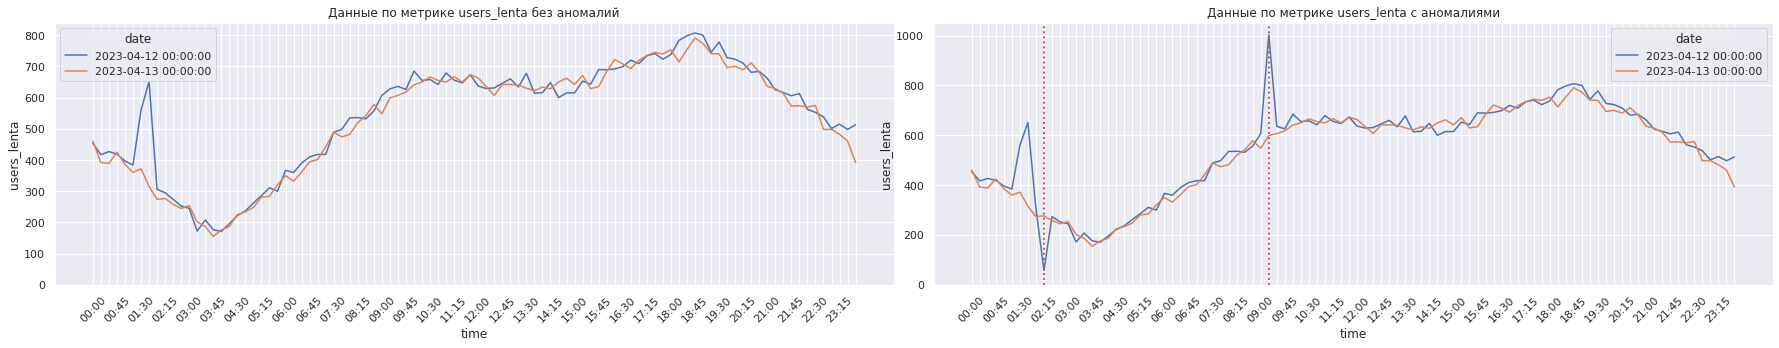

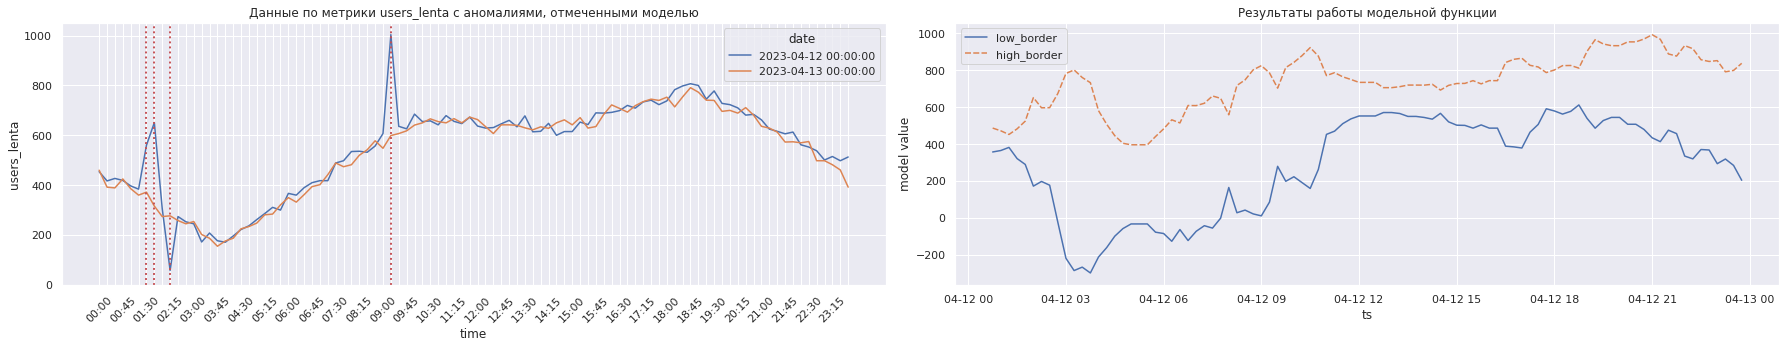

In [35]:
alert_data, true_alerts_value, all_trained_data, data_new, idx_anomalies, true_positives, false_negatives, true_negatives, false_positives = train_model(data, model=iqr_outlier,
                   model_params=dict(window=10, alpha=3.5),
                   anomalies_params=dict(anomalies_cnt = 2, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.5, anomalies_end=1.5))

In [17]:
true_positives, false_negatives, true_negatives, false_positives

(2, 0, 93, 1)

# Количество пользователей в ленте

Подберем сначала подходящую модель для метрики: количество пользователей в ленте

### ZSCORE

Прежде чем приступить к обучению модели, необходимо определиться с правилами, по которым мы будем добавлять аномалии. Хочется приблизить правила к максимально реалистичным условиям.
В реальности, крупных аномалии много подряд за раз часто не случается (скорее идет резкая просадка, которая потом остается на этом уровне если смотреть в рамках дня), поэтому общее число аномалий, которые будем добавлять, сделаем небольшим. Возьмем число = 3.

Далее надо определиться с величинами аномалий. Это лучше определять по историчесим данным. Это можно сделать, если посмотреть на распределение процентных изменений метрики в течение дня с разным сдвигом, и в качестве аномалий добавить нехаракерное для этой метрики изменение.

In [36]:
df_merged = data[data['date'] == '2023-04-12'].merge(data[data['date'] == '2023-04-13'], on='hm')

df_merged.head()

,ts_x,date_x,hm,users_lenta_x,ts_y,date_y,users_lenta_y
0,2023-04-12 00:00:00,2023-04-12,00:00,454,2023-04-13 00:00:00,2023-04-13,460
1,2023-04-12 00:15:00,2023-04-12,00:15,417,2023-04-13 00:15:00,2023-04-13,392
2,2023-04-12 00:30:00,2023-04-12,00:30,427,2023-04-13 00:30:00,2023-04-13,389
3,2023-04-12 00:45:00,2023-04-12,00:45,419,2023-04-13 00:45:00,2023-04-13,425
4,2023-04-12 01:00:00,2023-04-12,01:00,397,2023-04-13 01:00:00,2023-04-13,386


In [91]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 56
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ts_x           57 non-null     datetime64[ns]
 1   date_x         57 non-null     datetime64[ns]
 2   hm             57 non-null     object        
 3   users_lenta_x  57 non-null     uint64        
 4   ts_y           57 non-null     datetime64[ns]
 5   date_y         57 non-null     datetime64[ns]
 6   users_lenta_y  57 non-null     uint64        
dtypes: datetime64[ns](4), object(1), uint64(2)
memory usage: 3.6+ KB


In [59]:
df_merged.users_lenta_x.pct_change().quantile(0.99)

0.15108918128654963

<AxesSubplot:>

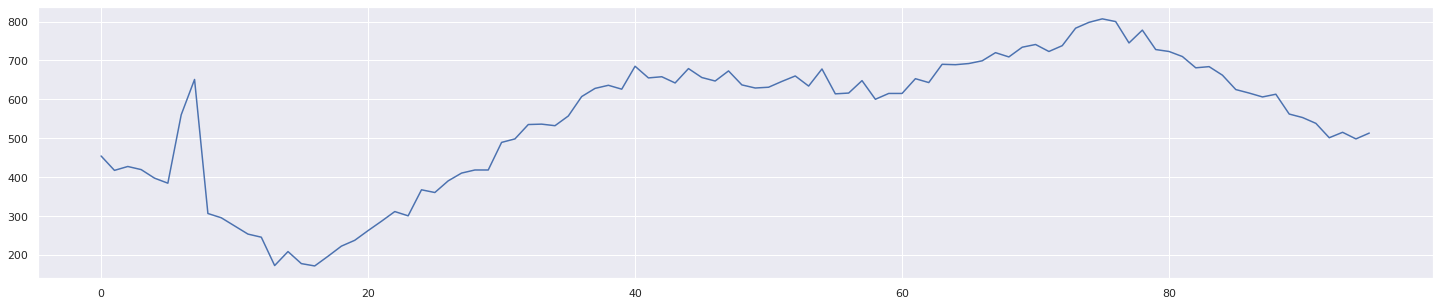

In [65]:
df_merged.users_lenta_x.plot()

<AxesSubplot:>

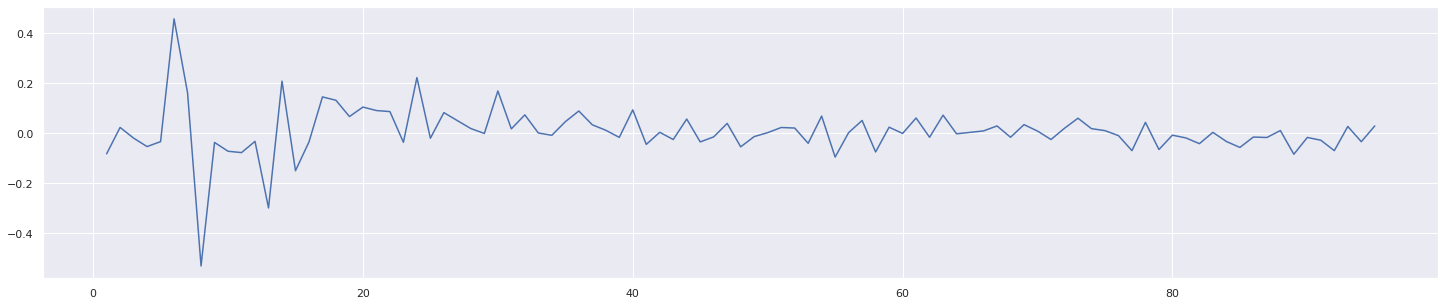

In [53]:
df_merged.users_lenta_x.pct_change().plot()

<AxesSubplot:>

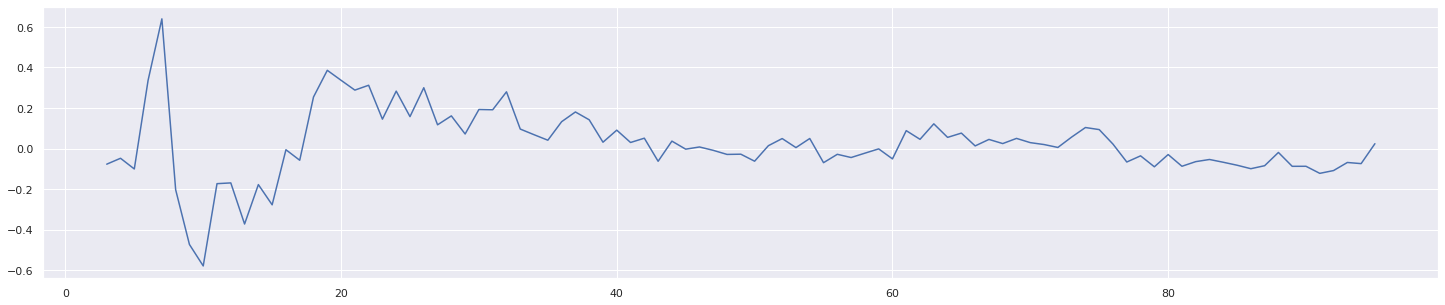

In [60]:
df_merged.users_lenta_x.pct_change(3).plot()

In [64]:
df_merged.users_lenta_x.pct_change(3).quantile(.99)

0.4062715983914443

Все, что метрика в целом несильно изменяется по сравнению с прошлым значением (кроме аномальных случаев)

100%|██████████| 12/12 [00:31<00:00,  2.62s/it]


,model,parameter,avg_error_diff,tpr,fpr,tnr,fnr
0,zscore,3,4.226667,0.890000,0.139892,0.860323,0.103333
1,zscore,4,2.723333,0.853333,0.092581,0.907742,0.136667
2,zscore,5,1.700000,0.793333,0.061505,0.938925,0.193333
3,zscore,6,0.820000,0.750000,0.034516,0.965806,0.240000
4,zscore,7,0.780000,0.766667,0.032688,0.967419,0.230000
5,zscore,8,1.000000,0.756667,0.040108,0.960108,0.236667
6,zscore,9,-0.066667,0.683333,0.008065,0.992043,0.313333
7,zscore,10,-0.086667,0.670000,0.007849,0.992796,0.310000
8,zscore,11,0.120000,0.680000,0.014194,0.986237,0.306667
9,zscore,12,0.093333,0.653333,0.014194,0.986237,0.333333


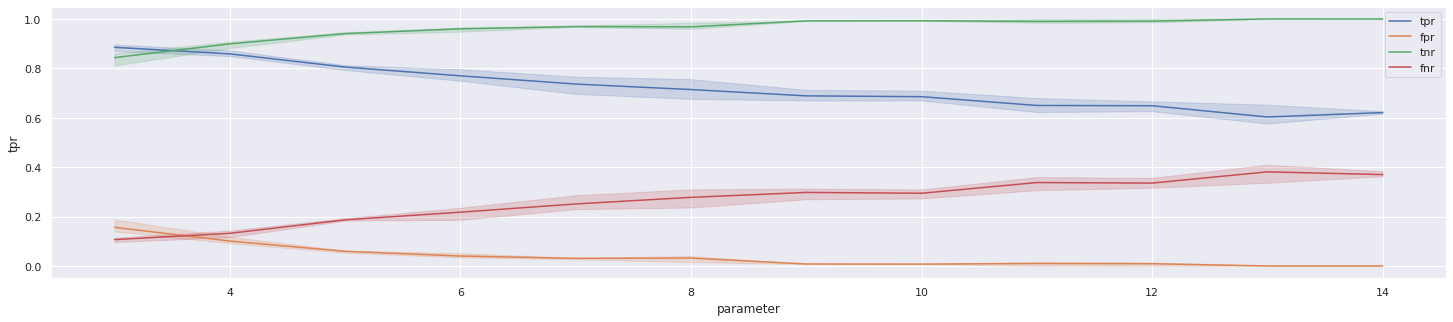

In [89]:
steps = 100

window_sizes = np.arange(3, 15, 1)


alpha_values = np.arange(1.5, 5, 0.5)

metric = 'users_lenta'

anomalies_param = dict(anomalies_cnt = 3, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.3, anomalies_end=1)

find_parameters_zscore(window_sizes, steps, metric, anomalies_param)

Видим, что способ детектирования аномалий, когда мы используем z-score работает не очень хорошо: с ростом размера окна у нас будет расти false negative, что не очень хорошо для системы алертинга.

### IQR

100%|██████████| 12/12 [18:45<00:00, 93.81s/it]


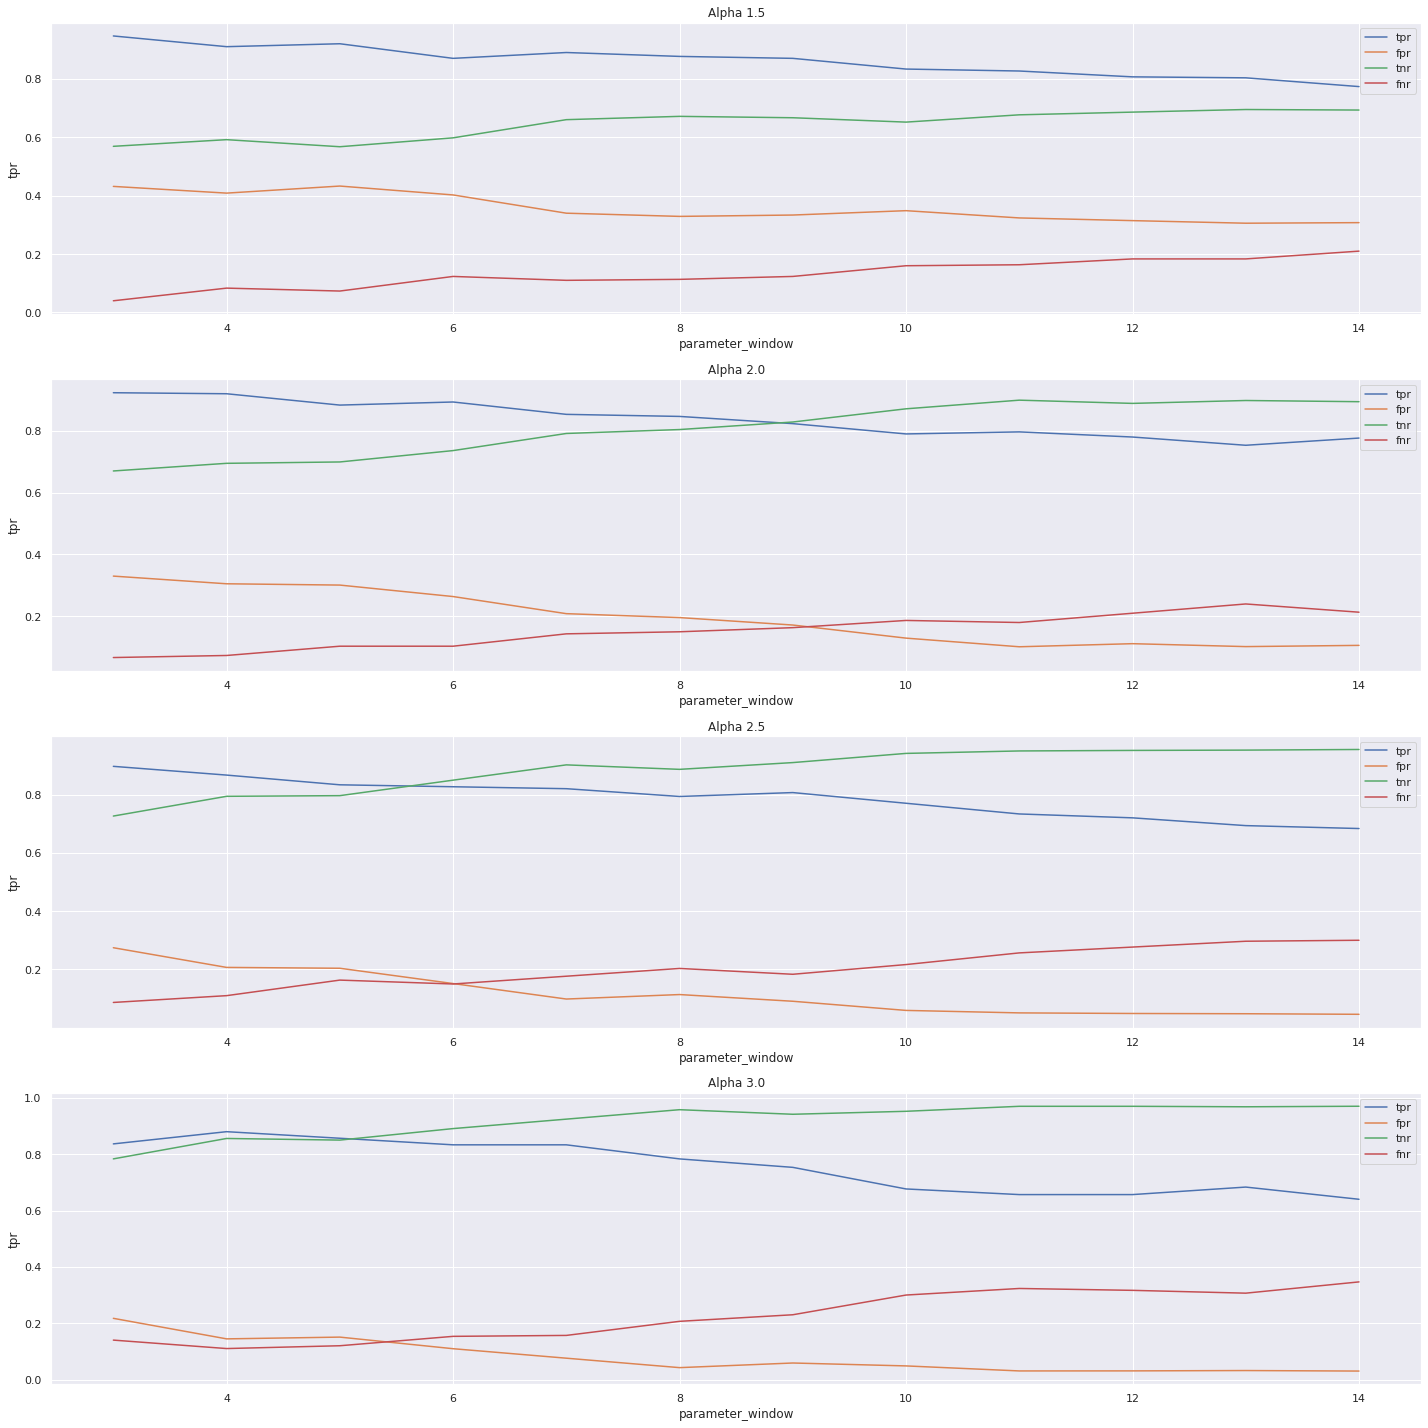

In [90]:
steps = 100

window_sizes = np.arange(3, 15, 1)


anomalies_param = dict(anomalies_cnt = 3, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.3, anomalies_end=1)

metric = 'users_lenta'

alpha_values = np.arange(1.5, 3.5, 0.5)

result_df = find_parameters_iqr(window_sizes, alpha_values, steps, metric, anom=anomalies_param)

Вариант с iqr в целом работает лучше, чем zscore. Видно, что с ростом параметра alpha падает количество ложно положительных срабатываний, но растет количество ложно отрицательных срабатываний.
Для данной метрики лучше брать alpha = 3 и размер окна = 8: при этом мы будем иметь мощность на уровне 80%, при этом ложных срабатываний будет на уровне 5%.
Аналогичные показатели достигаются для окна размером = 6 для zscore, хотя при этом мощность все таки чуть меньше 80%

# Количество пользователей в мессенджере

In [91]:
q = ''' SELECT
                          toStartOfFifteenMinutes(time) as ts
                        , toDate(ts) as date
                        , formatDateTime(ts, '%R') as hm
                        , uniqExact(user_id) as users_message
                    FROM {db}.message_actions
                    WHERE ts >=  today() - 4 and ts < toStartOfFifteenMinutes(now()) - 3
                    GROUP BY ts, date, hm
                    ORDER BY ts'''  

data = Getch(q, db='simulator_20230220').df


In [84]:
data

,ts,date,hm,users_message
0,2023-04-12 00:00:00,2023-04-12,00:00,83
1,2023-04-12 00:15:00,2023-04-12,00:15,74
2,2023-04-12 00:30:00,2023-04-12,00:30,61
3,2023-04-12 00:45:00,2023-04-12,00:45,61
4,2023-04-12 01:00:00,2023-04-12,01:00,68
...,...,...,...,...
188,2023-04-13 23:00:00,2023-04-13,23:00,64
189,2023-04-13 23:15:00,2023-04-13,23:15,76
190,2023-04-13 23:30:00,2023-04-13,23:30,61
191,2023-04-13 23:45:00,2023-04-13,23:45,256


5 alerts are detected
2 alerts are expected
abs diff: 3


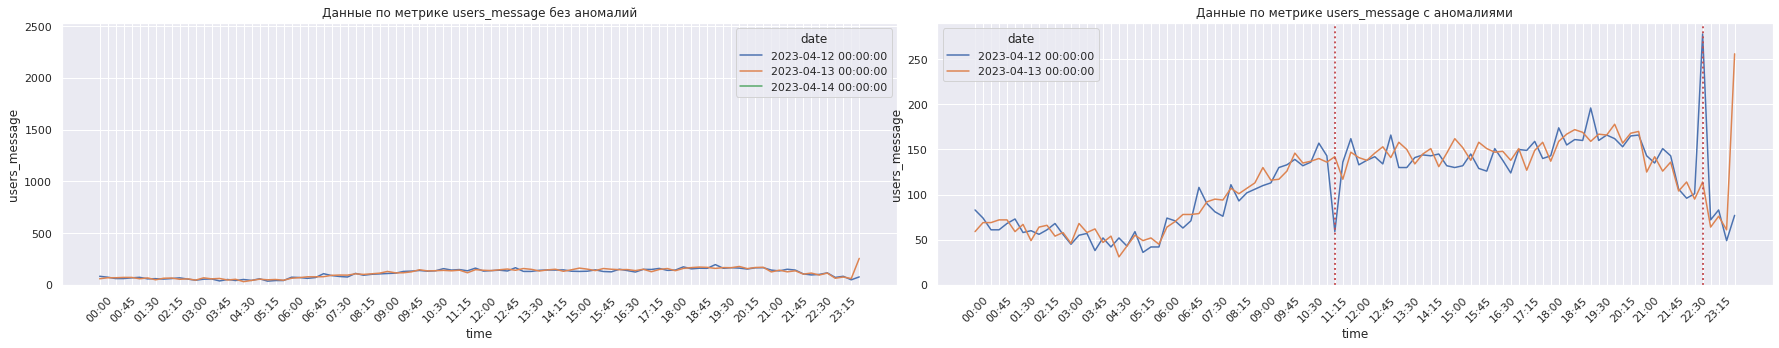

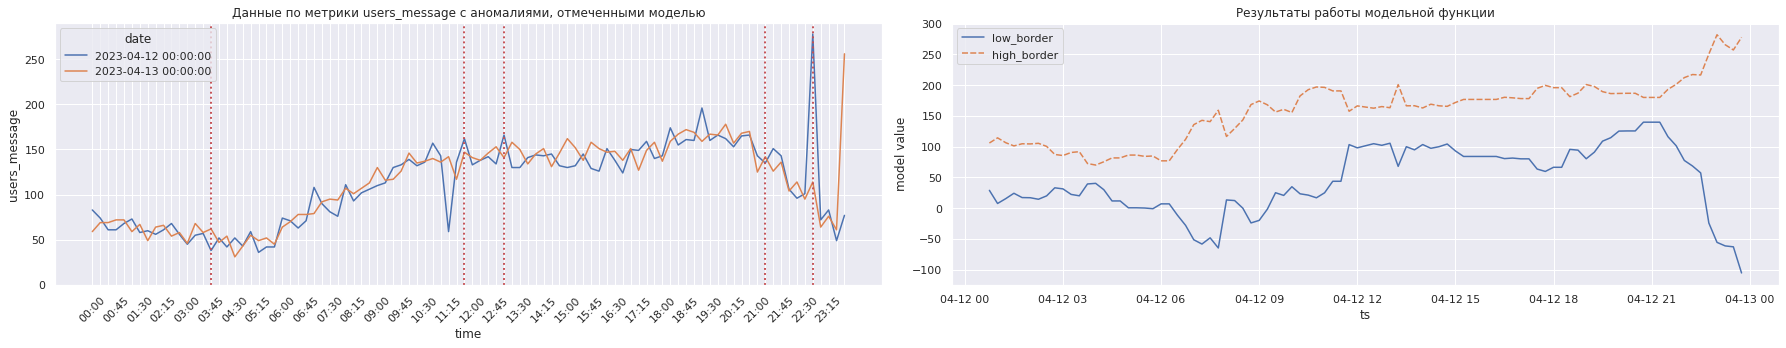

In [89]:
alert_data, true_alerts_value, all_trained_data, data_new, idx_anomalies, true_positives, false_negatives, true_negatives, false_positives = train_model(
                data, model=iqr_outlier, metric='users_message',
                   model_params=dict(window=10, alpha=3.5),
                   anomalies_params=dict(anomalies_cnt = 2, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.5, anomalies_end=1.5))

In [90]:
df_merged = data[data['date'] == '2023-04-12'].merge(data[data['date'] == '2023-04-13'], on='hm')

df_merged.head()

,ts_x,date_x,hm,users_message_x,ts_y,date_y,users_message_y
0,2023-04-12 00:00:00,2023-04-12,00:00,83,2023-04-13 00:00:00,2023-04-13,59
1,2023-04-12 00:15:00,2023-04-12,00:15,74,2023-04-13 00:15:00,2023-04-13,69
2,2023-04-12 00:30:00,2023-04-12,00:30,61,2023-04-13 00:30:00,2023-04-13,69
3,2023-04-12 00:45:00,2023-04-12,00:45,61,2023-04-13 00:45:00,2023-04-13,72
4,2023-04-12 01:00:00,2023-04-12,01:00,68,2023-04-13 01:00:00,2023-04-13,72


<AxesSubplot:>

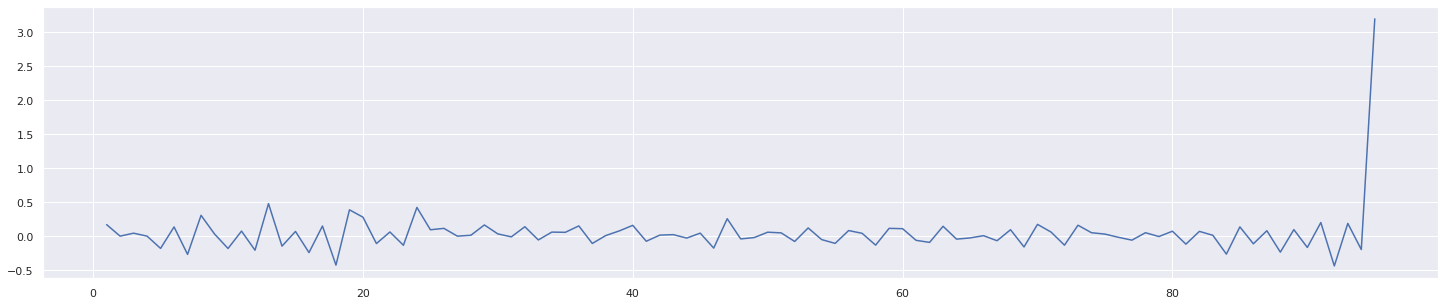

In [91]:
df_merged.users_message_y.pct_change().plot()

<AxesSubplot:>

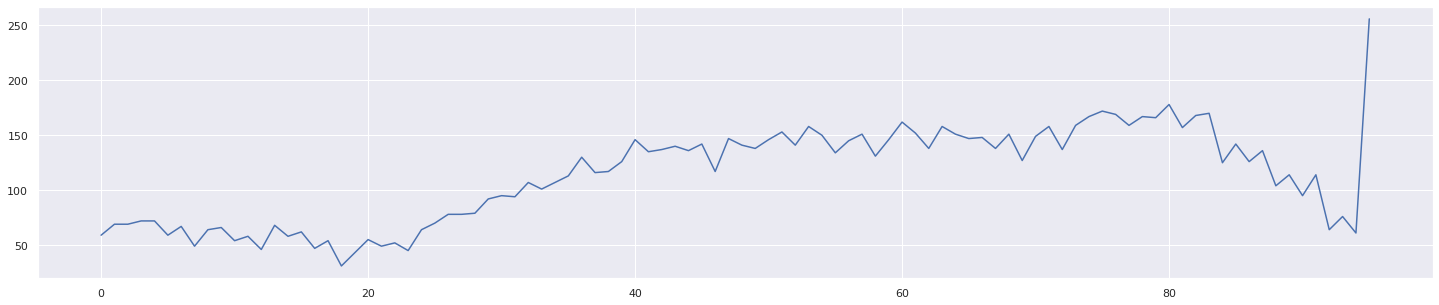

In [93]:
df_merged.users_message_y.plot()

<AxesSubplot:>

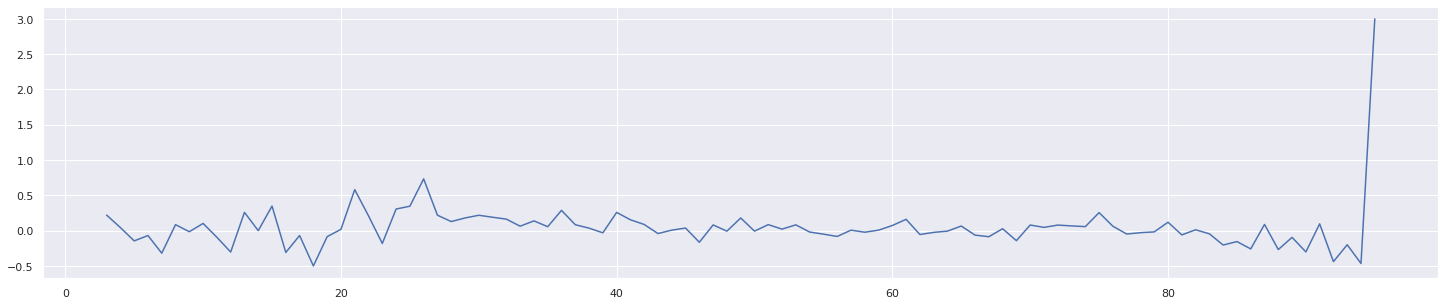

In [94]:
df_merged.users_message_y.pct_change(3).plot()

Значения у метрики по абсолютам маленькие, изменения в рамках дня варьируются достаточно сильно.

### Zscore

100%|██████████| 12/12 [00:32<00:00,  2.75s/it]


,model,parameter,avg_error_diff,tpr,fpr,tnr,fnr
0,zscore,3,4.226667,0.890000,0.139892,0.860323,0.103333
1,zscore,4,2.723333,0.853333,0.092581,0.907742,0.136667
2,zscore,5,1.700000,0.793333,0.061505,0.938925,0.193333
3,zscore,6,0.820000,0.750000,0.034516,0.965806,0.240000
4,zscore,7,0.780000,0.766667,0.032688,0.967419,0.230000
5,zscore,8,1.000000,0.756667,0.040108,0.960108,0.236667
6,zscore,9,-0.066667,0.683333,0.008065,0.992043,0.313333
7,zscore,10,-0.086667,0.670000,0.007849,0.992796,0.310000
8,zscore,11,0.120000,0.680000,0.014194,0.986237,0.306667
9,zscore,12,0.093333,0.653333,0.014194,0.986237,0.333333


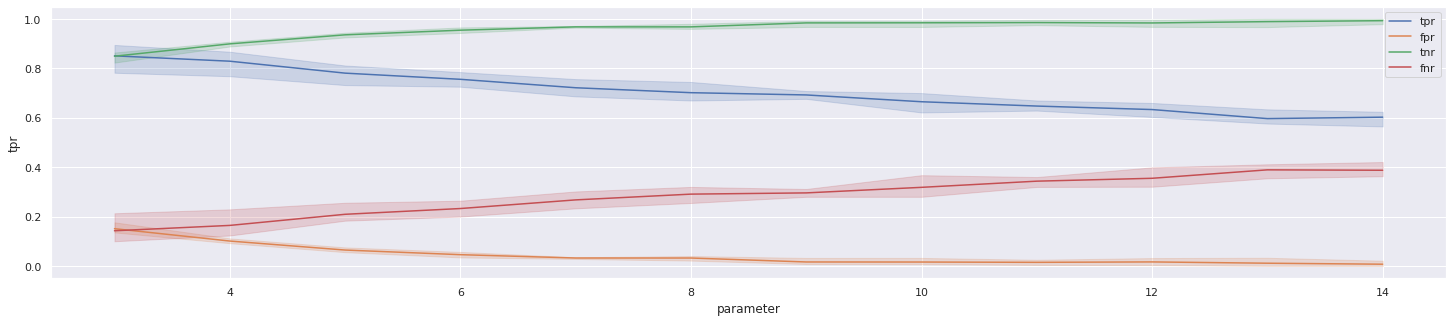

In [92]:
steps = 100

window_sizes = np.arange(3, 15, 1)


alpha_values = np.arange(1.5, 5, 0.5)

metric = 'users_message'

anomalies_param = dict(anomalies_cnt = 3, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.3, anomalies_end=1)

find_parameters_zscore(window_sizes, steps, metric, anomalies_param)

### IQR

100%|██████████| 12/12 [18:37<00:00, 93.13s/it]


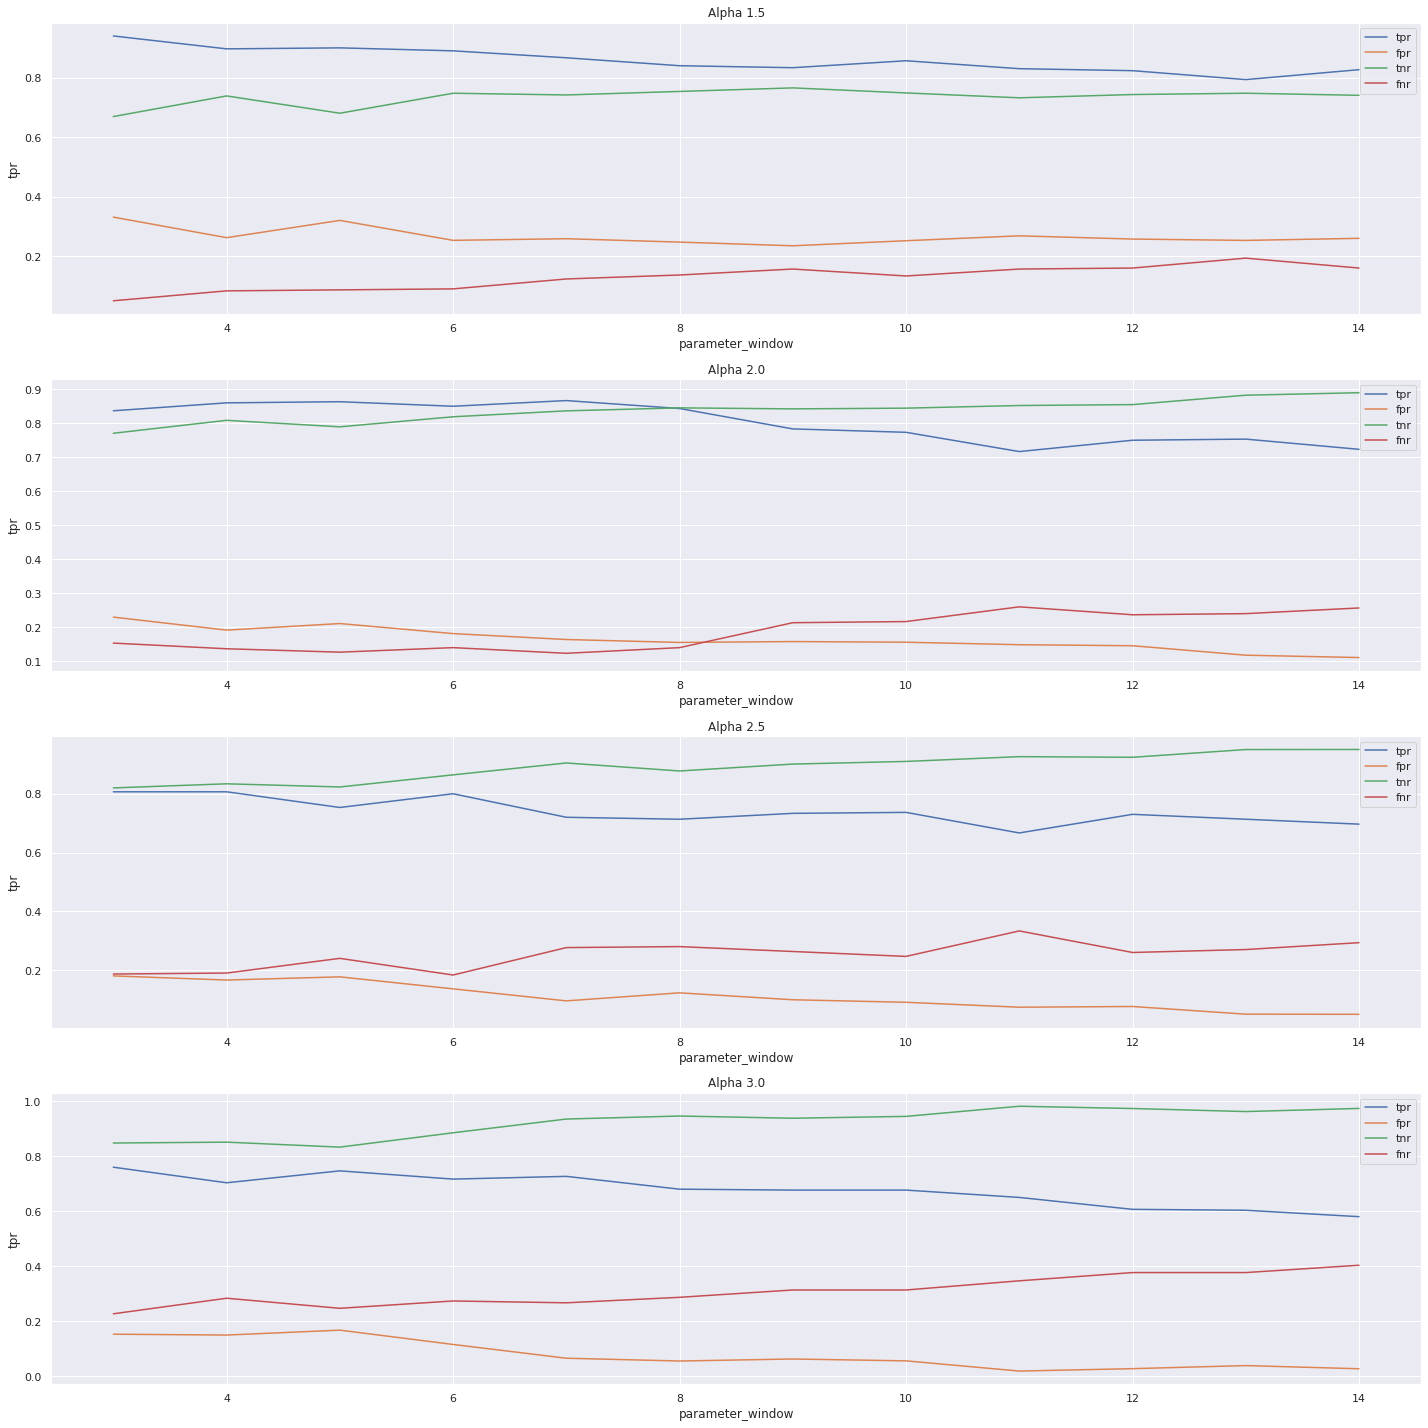

In [93]:
steps = 100

window_sizes = np.arange(3, 15, 1)


anomalies_param = dict(anomalies_cnt = 3, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.3, anomalies_end=1)

metric = 'users_message'

alpha_values = np.arange(1.5, 3.5, 0.5)

result_df = find_parameters_iqr(window_sizes, alpha_values, steps, metric, anom=anomalies_param)

Интересно, что для данной метрики iqr проигрывает zscore. В целом его показатели работы хуже, чем для zscore.
Поэтоу для данной метрики следует выбрать zscore с окном=3, так как мы хотим как можно меньшьее false negatives.

# Просмотры в ленте

In [12]:
q = ''' SELECT
                          toStartOfFifteenMinutes(time) as ts
                        , toDate(ts) as date
                        , formatDateTime(ts, '%R') as hm
                        , count(user_id) as view
                    FROM {db}.feed_actions
                    WHERE ts >=  today() - 4 and ts < toStartOfFifteenMinutes(now())-3 and action = 'view'
                    GROUP BY ts, date, hm
                    ORDER BY ts'''  

data = Getch(q, db='simulator_20230220').df


In [74]:
data.head()

,ts,date,hm,view
0,2023-04-12 00:00:00,2023-04-12,00:00,7410
1,2023-04-12 00:15:00,2023-04-12,00:15,6677
2,2023-04-12 00:30:00,2023-04-12,00:30,6954
3,2023-04-12 00:45:00,2023-04-12,00:45,7096
4,2023-04-12 01:00:00,2023-04-12,01:00,6486


2 alerts are detected
0 alerts are expected
abs diff: 2


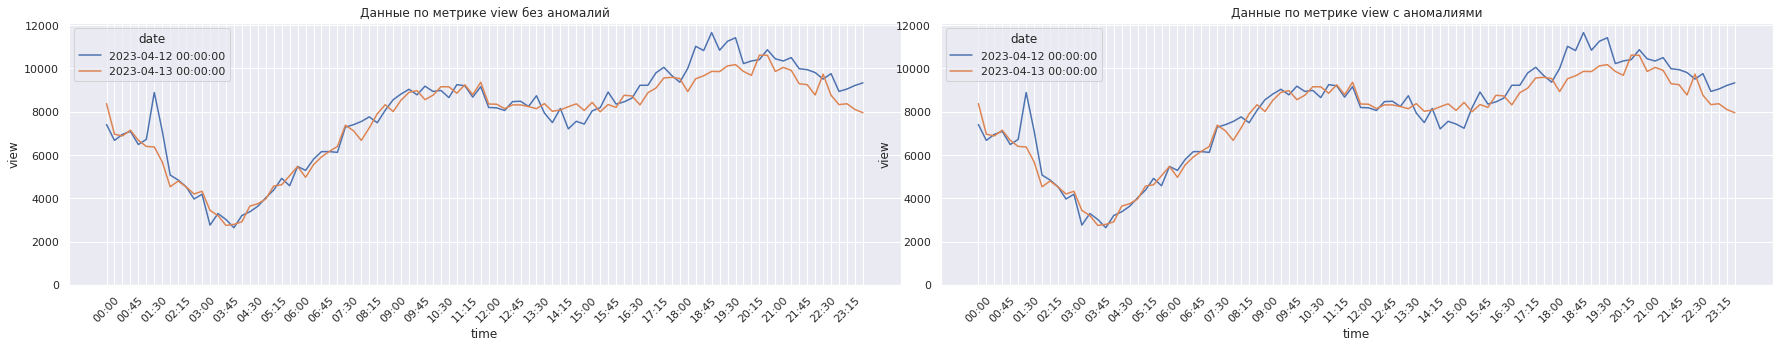

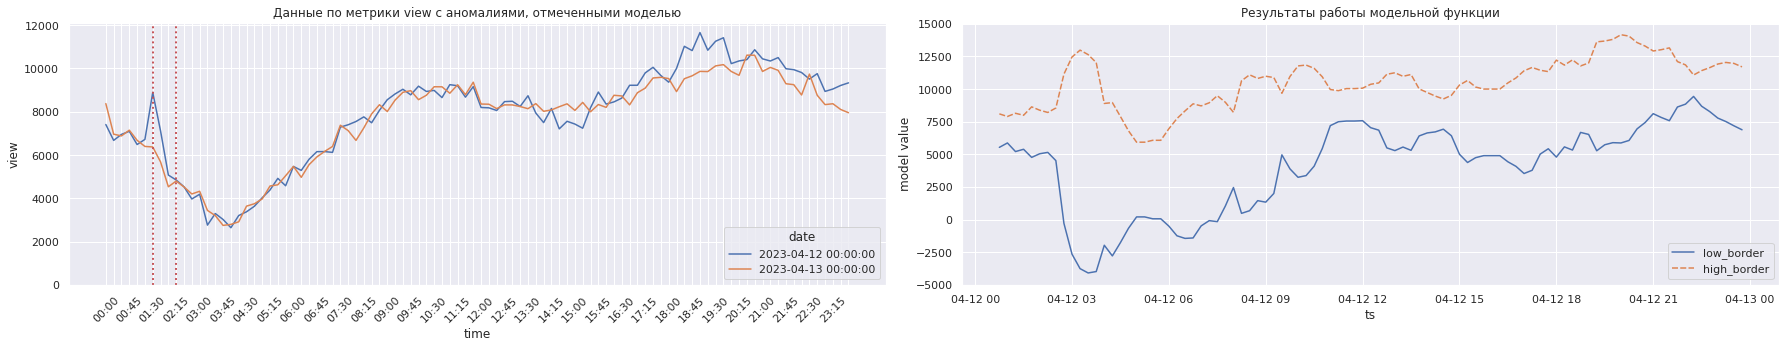

In [75]:
alert_data, true_alerts_value, all_trained_data, data_new, idx_anomalies, true_positives, false_negatives, true_negatives, false_positives = train_model(
                data, model=iqr_outlier, metric='view',
                   model_params=dict(window=10, alpha=3.5),
                   anomalies_params=dict(anomalies_cnt = 2, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.5, anomalies_end=1.5))

### Zscore

In [15]:
steps = 100

window_sizes = np.arange(3, 15, 1)


alpha_values = np.arange(1.5, 5, 0.5)

metric = 'view'

In [96]:
anomalies_param = dict(anomalies_cnt = 3, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.3, anomalies_end=1)

100%|██████████| 12/12 [00:29<00:00,  2.48s/it]


,model,parameter,avg_error_diff,tpr,fpr,tnr,fnr
0,zscore,3,4.306667,0.860000,0.143441,0.856882,0.130000
1,zscore,4,2.700000,0.833333,0.092473,0.907742,0.160000
2,zscore,5,1.860000,0.833333,0.065376,0.934946,0.156667
3,zscore,6,0.850000,0.753333,0.035376,0.964946,0.236667
4,zscore,7,0.790000,0.740000,0.033871,0.966344,0.253333
5,zscore,8,0.966667,0.706667,0.040645,0.959785,0.280000
6,zscore,9,-0.050000,0.720000,0.007419,0.993011,0.266667
7,zscore,10,-0.076667,0.673333,0.008065,0.992151,0.320000
8,zscore,11,0.116667,0.656667,0.014839,0.985161,0.343333
9,zscore,12,0.063333,0.683333,0.012258,0.988280,0.300000


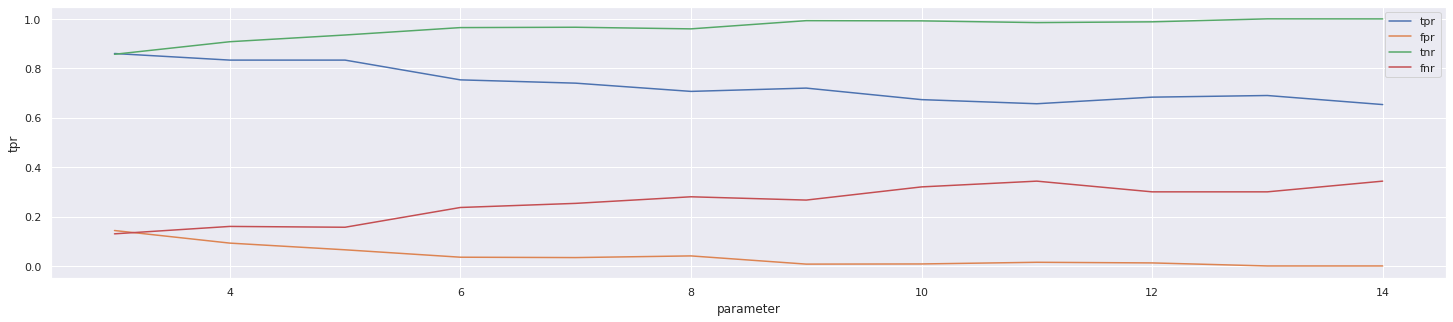

In [97]:
find_parameters_zscore(window_sizes, steps, metric, anomalies_param)

### IQR

100%|██████████| 12/12 [19:41<00:00, 98.44s/it]


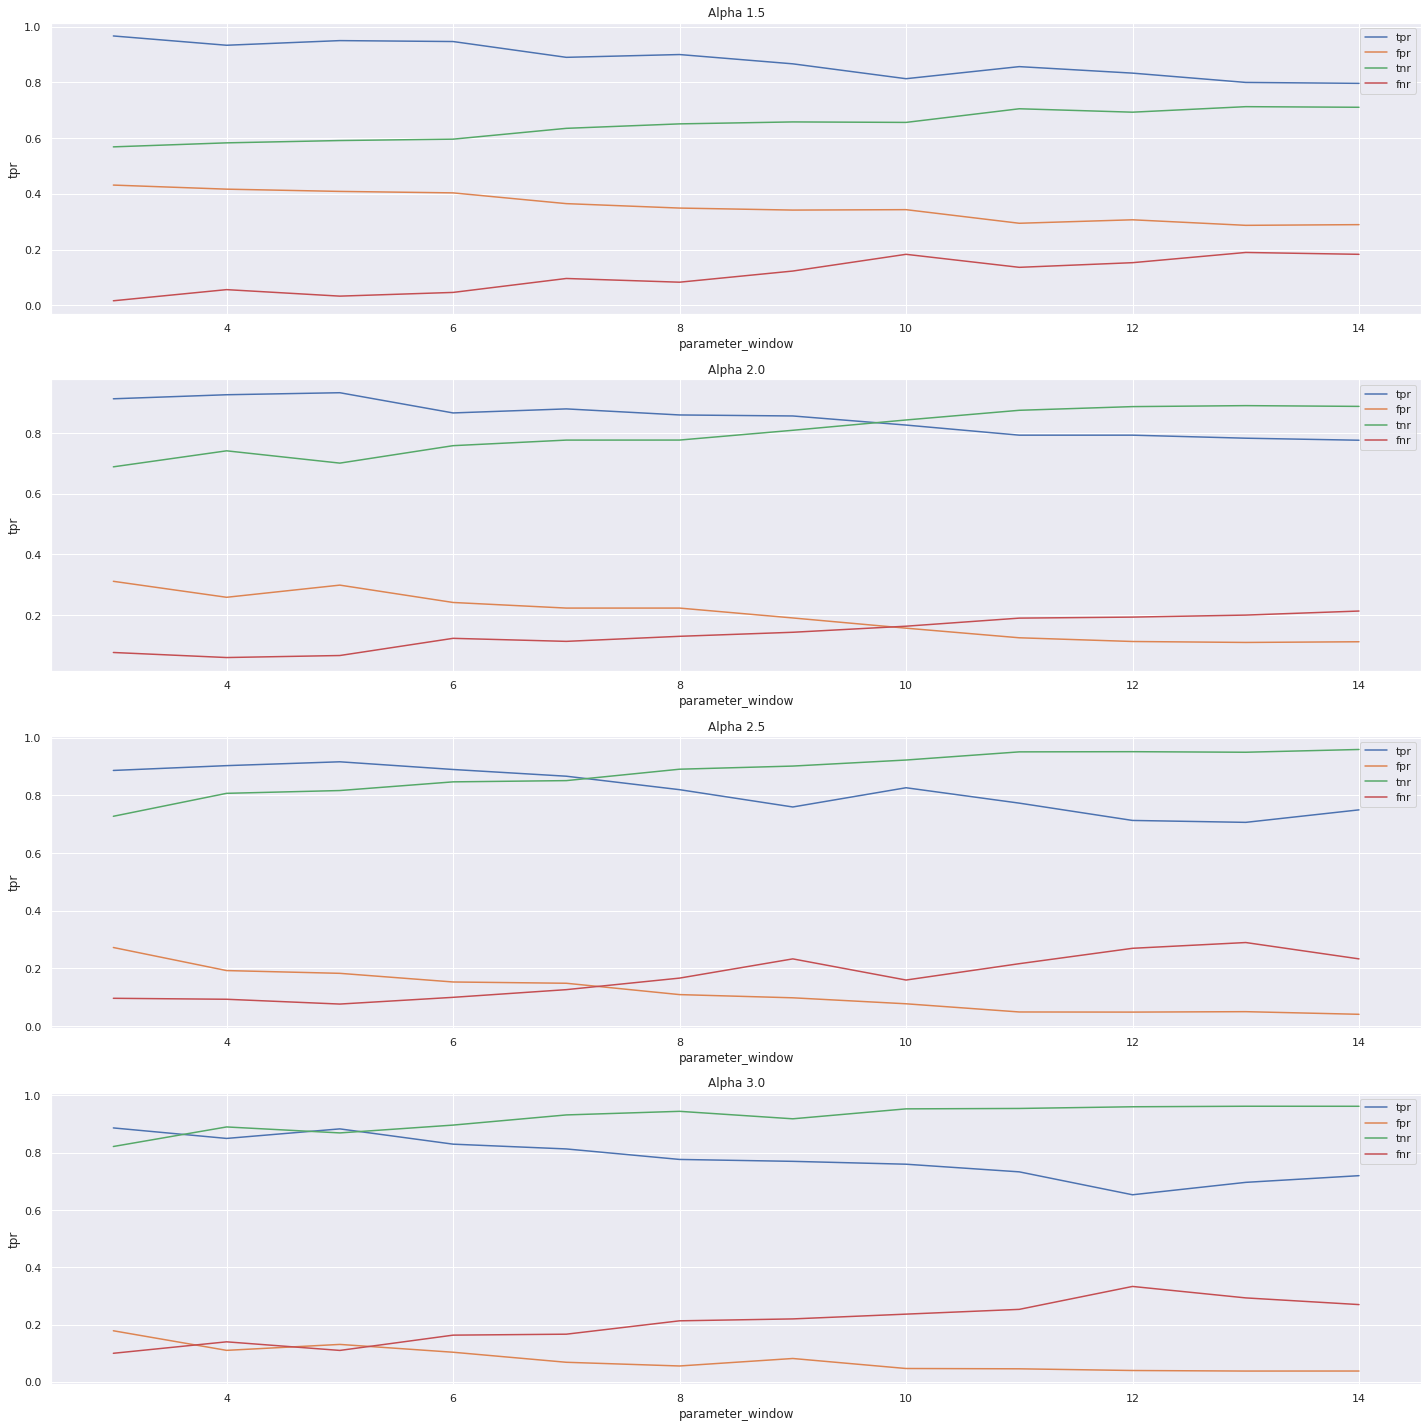

In [16]:
metric = 'view'

anomalies_param = dict(anomalies_cnt = 3, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.3, anomalies_end=1)

alpha_values = np.arange(1.5, 3.5, 0.5)

result_df = find_parameters_iqr(window_sizes, alpha_values, steps, metric, anom=anomalies_param)

Также остановимся на zscore(4)

# CTR

In [79]:
q = ''' SELECT
                          toStartOfFifteenMinutes(time) as ts
                        , toDate(ts) as date
                        , formatDateTime(ts, '%R') as hm
                        , countIf(user_id, action='like') / countIf(user_id, action='view') as ctr
                    FROM {db}.feed_actions
                    WHERE ts >=  today() - 4 and ts < toStartOfFifteenMinutes(now())-3
                    GROUP BY ts, date, hm
                    ORDER BY ts'''  

data = Getch(q, db='simulator_20230220').df


In [80]:
data.date.unique()

array(['2023-04-12T00:00:00.000000000', '2023-04-13T00:00:00.000000000'],
      dtype='datetime64[ns]')

4 alerts are detected
2 alerts are expected
abs diff: 2


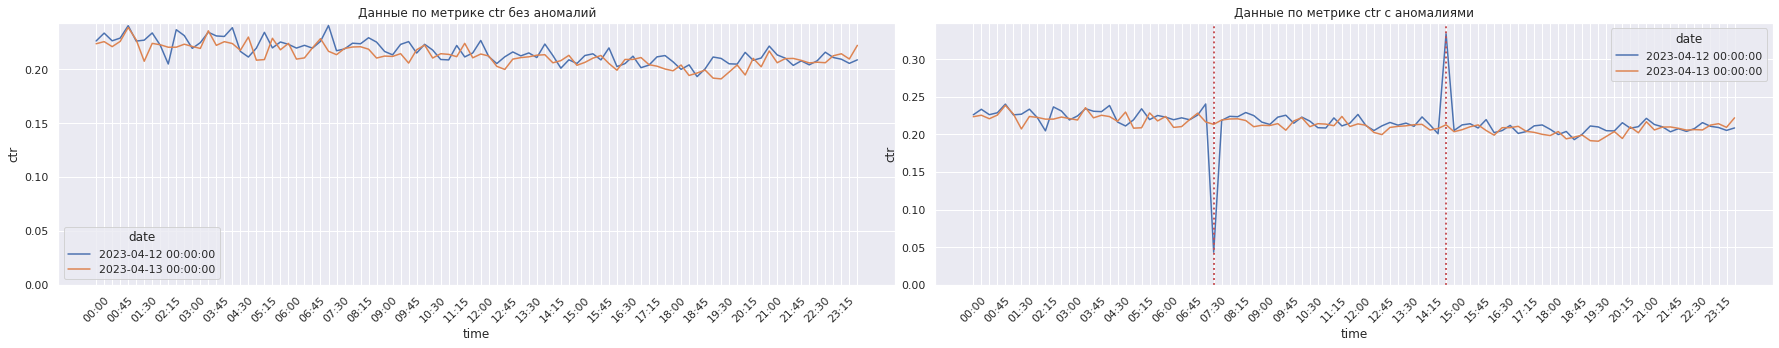

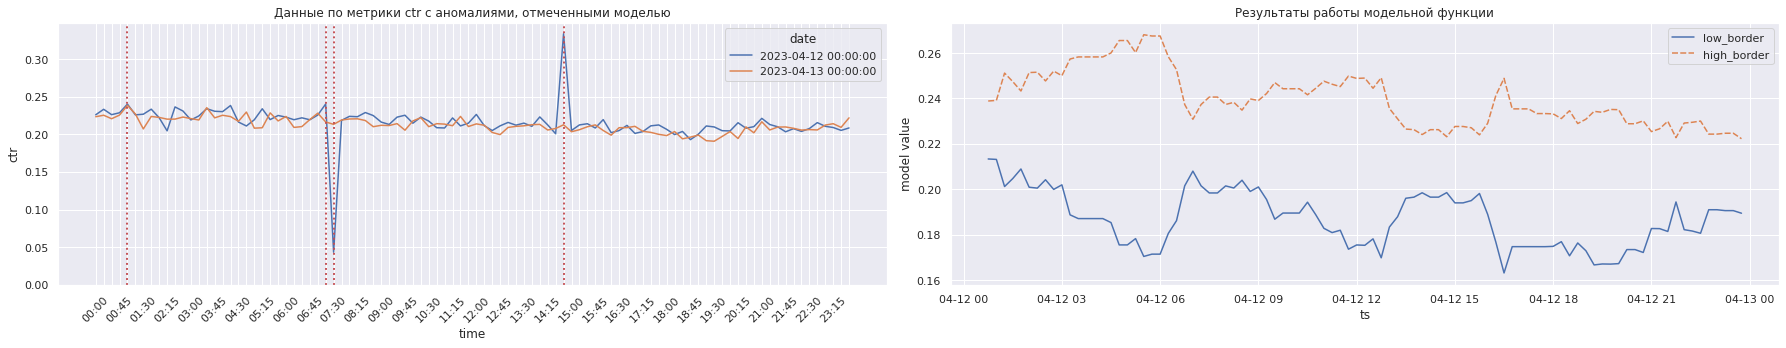

In [61]:
alert_data, true_alerts_value, all_trained_data, data_new, idx_anomalies, true_positives, false_negatives, true_negatives, false_positives = train_model(
                data, model=iqr_outlier, metric='ctr',
                   model_params=dict(window=10, alpha=3.5),
                   anomalies_params=dict(anomalies_cnt = 2, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.5, anomalies_end=1.5))

In [62]:
sum_val = 0
tpr_cycle = 0
fpr_cycle = 0
tnr_cycle = 0
fnr_cycle = 0

sum_val += (len(alert_data) - true_alerts_value)/(true_alerts_value if true_alerts_value else 1)
data_len = len(all_trained_data)

tpr_cycle += true_positives / len(idx_anomalies) if len(idx_anomalies) > 0 else 0
fpr_cycle += false_positives / (true_negatives + false_positives)
tnr_cycle += true_negatives / (true_negatives + false_positives)
fnr_cycle += false_negatives / len(idx_anomalies) if len(idx_anomalies) > 0 else 0


In [68]:
tpr_cycle

1.0

9 alerts are detected
2 alerts are expected
abs diff: 7


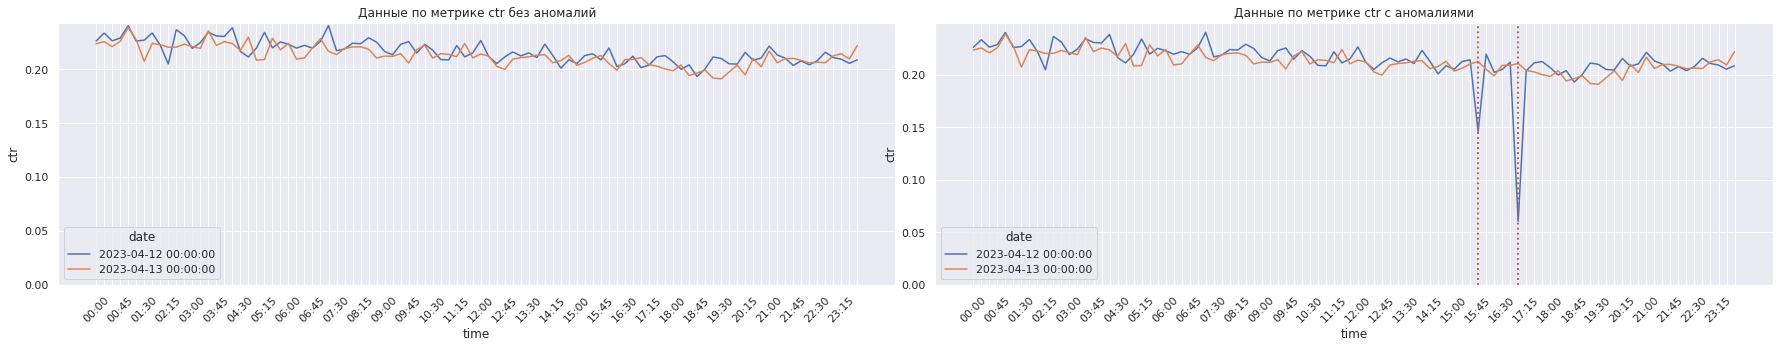

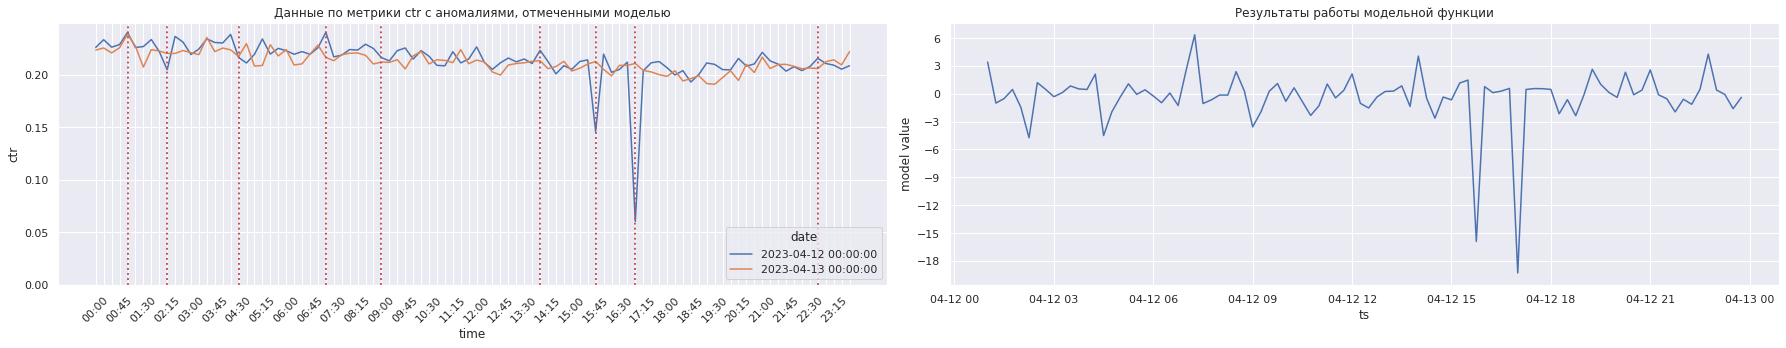

In [38]:
alert_data, true_alerts_value, all_trained_data, data_new, idx_anomalies, true_positives, false_negatives, true_negatives, false_positives = train_model(
                data, model=zscore, metric='ctr',
                   model_params=dict(window=4, alpha=3.5),
                   anomalies_params=dict(anomalies_cnt = 2, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.5, anomalies_end=1.5))

In [60]:
tnr_cycle

0.925531914893617

In [59]:
sum_val = 0
tpr_cycle = 0
fpr_cycle = 0
tnr_cycle = 0
fnr_cycle = 0

sum_val += (len(alert_data) - true_alerts_value)/(true_alerts_value if true_alerts_value else 1)
data_len = len(all_trained_data)

tpr_cycle += true_positives / len(idx_anomalies) if len(idx_anomalies) > 0 else 0
fpr_cycle += false_positives / (true_negatives + false_positives)
tnr_cycle += true_negatives / (true_negatives + false_positives)
fnr_cycle += false_negatives / len(idx_anomalies) if len(idx_anomalies) > 0 else 0


In [52]:
fpr_cycle

0.07446808510638298

In [48]:
for w in tqdm(window_sizes):
        sum_val = 0
        tpr_cycle = 0
        fpr_cycle = 0
        tnr_cycle = 0
        fnr_cycle = 0
        for i in range(steps):

            sum_val += (len(alert_data) - true_alerts_value)/(true_alerts_value if true_alerts_value else 1)
            data_len = len(all_trained_data)

            tpr_cycle += true_positives / len(idx_anomalies) if len(idx_anomalies) > 0 else 0
            fpr_cycle += false_positives / (data_len - len(idx_anomalies))
            tnr_cycle += true_negatives / (data_len - len(idx_anomalies))
            fnr_cycle += false_negatives / len(idx_anomalies) if len(idx_anomalies) > 0 else 0


        z_results.append(('zscore', w, sum_val / steps, tpr_cycle / steps, fpr_cycle / steps, tnr_cycle / steps, fnr_cycle / steps))
    result_df = pd.DataFrame(z_results, columns=['model', 'parameter', 'avg_error_diff', 'tpr', 'fpr', 'tnr', 'fnr'])
    
    for column in ['tpr', 'fpr', 'tnr', 'fnr']:
        sns.lineplot( # строим линейный график
                x=result_df.parameter, y=result_df[column], label=column
                );
    return result_df

[Timestamp('2023-04-12 15:45:00'), Timestamp('2023-04-12 17:00:00')]

In [179]:
z_results = []

window_sizes = np.arange(3, 15, 1)
alpha_values = np.arange(1.5, 5, 0.5)

steps = 100

metric = 'ctr'

anomalies_param = dict(anomalies_cnt = 3, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.3, anomalies_end=1)

100%|██████████| 12/12 [00:23<00:00,  1.94s/it]


,model,parameter,avg_error_diff,tpr,fpr,tnr,fnr
0,zscore,3,3.123333,0.953333,0.102258,0.897957,0.040000
1,zscore,4,1.913333,0.900000,0.064946,0.935806,0.076667
2,zscore,5,0.956667,0.880000,0.034731,0.966022,0.096667
3,zscore,6,1.180000,0.856667,0.042688,0.957634,0.133333
4,zscore,7,1.120000,0.840000,0.041290,0.959032,0.150000
5,zscore,8,0.423333,0.880000,0.017527,0.982688,0.113333
6,zscore,9,0.403333,0.876667,0.016989,0.983226,0.116667
7,zscore,10,0.080000,0.853333,0.007312,0.992796,0.143333
8,zscore,11,0.026667,0.800000,0.007312,0.992903,0.193333
9,zscore,12,-0.183333,0.816667,0.000000,1.000323,0.173333


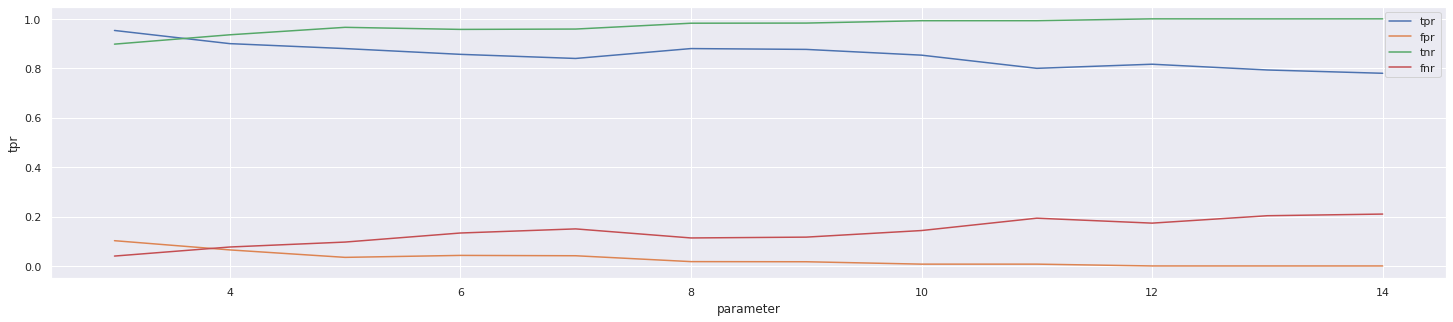

In [180]:
find_parameters_zscore(window_sizes, steps, metric, anomalies_param)

100%|██████████| 12/12 [01:53<00:00,  9.45s/it]


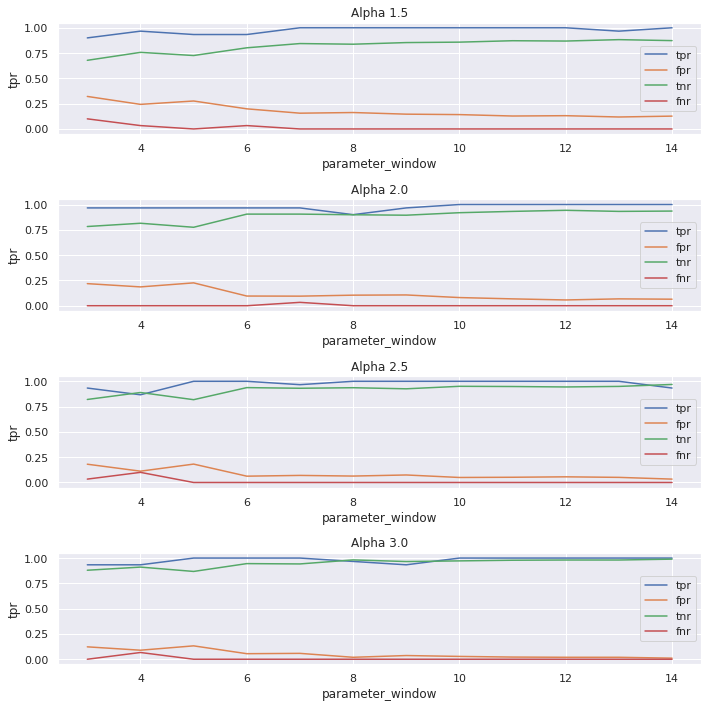

In [70]:


metric = 'ctr'

anomalies_param = dict(anomalies_cnt = 3, anomalies_border = 0.3, anomalies_step = 0.1, anomalies_start=0.3, anomalies_end=1)

window_sizes = np.arange(3, 15, 1)
alpha_values = np.arange(1.5, 3.5, 0.5)

steps = 10

result_df = find_parameters_iqr(window_sizes, alpha_values, steps, metric, anom =anomalies_param)

Метрика ctr наименее шумная из всех рассмотреных, поэтому обе модели отработали лучше, чем на других метрик. При этом для модели iqr достигается почти идеальная эффективность уже при размере окна = 8 и alpha=3. Интересно, что zscore в целом проявила себя хуже, чем iqr: с ростом размера окна падает true positives и растет false negative, последнее для нашей системы алертинга крайне нежелательно. Поэтому будем использовать iqr с window_size=8 и alpha=3

# Итоги подбора

Были рассмотрены метрики:

- Количество пользователей в ленте
- Количество пользователей в сообщениях
- Количество лайков
- CTR

Были выявлены следующие закономерности: чем меньше дисперсия метрики, тем выше доля true positives rate при аналогичном значении параметра окна. Также на менее шумных метриках iqr справляется лучше, а на более шумных - zscore справляется лучше.

# Пример отправки оповещений через бота в тг

In [ ]:
import telegram plt
import seaborn as sns
import io
import os
from datetime import datetime, timedelta

from airflow.decorators import dag, task
from airflow.operators.python import get_current_context

sns.set()


In [ ]:
metrics_params = {'users_lenta': (''' SELECT
                          toStartOfFifteenMinutes(time) as ts
                        , toDate(ts) as date
                        , formatDateTime(ts, '%R') as hm
                        , uniqExact(user_id) as users_lenta
                    FROM {db}.feed_actions
                    WHERE ts >=  today() - 1  and ts <= toStartOfFifteenMinutes(now())
                    GROUP BY ts, date, hm
                    ORDER BY ts''', iqr_outlier, {'window_size': 8, 'alpha' : 3}),
'users_message': (''' SELECT
                          toStartOfFifteenMinutes(time) as ts
                        , toDate(ts) as date
                        , formatDateTime(ts, '%R') as hm
                        , uniqExact(user_id) as users_message
                    FROM {db}.message_actions
                    WHERE ts >=  today() - 1  and ts <= toStartOfFifteenMinutes(now())
                    GROUP BY ts, date, hm
                    ORDER BY ts''', zscore, {'window_size': 3}),
                
'view': (''' SELECT
                          toStartOfFifteenMinutes(time) as ts
                        , toDate(ts) as date
                        , formatDateTime(ts, '%R') as hm
                        , count(user_id) as view
                    FROM {db}.feed_actions
                    WHERE ts >=  today() - 1 and ts <= toStartOfFifteenMinutes(now()) and action = 'view'
                    GROUP BY ts, date, hm
                    ORDER BY ts''', iqr_outlier,  {'window_size': 5, 'alpha' : 3}),
 'ctr' (''' SELECT
                          toStartOfFifteenMinutes(time) as ts
                        , toDate(ts) as date
                        , formatDateTime(ts, '%R') as hm
                        , countIf(user_id, action='like') / countIf(user_id, action='view') as ctr
                    FROM {db}.feed_actions
                    WHERE ts >=  today() - 1  and ts <= toStartOfFifteenMinutes(now())
                    GROUP BY ts, date, hm
                    ORDER BY ts''', iqr_outlier,  {'window_size': 8, 'alpha' : 3}  )

}

In [ ]:
# Дефолтные параметры, которые прокидываются в таски
default_args = {
    'owner': 'sv_alert_sustem',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
    'start_date': datetime(2023, 3, 26),
}

# Интервал запуска DAG
schedule_interval = '0 12 * * *'


class Getch:
    def __init__(self, query, db='...'):
        self.connection = {
            'host': '....',
            'password': '...',
            'user': '....',
            'database': db,
        }
        self.query = query
        self.getchdf

    @property
    def getchdf(self):
        try:
            self.df = pandahouse.read_clickhouse(self.query, connection=self.connection)

        except Exception as err:
            print("\033[31m {}".format(err))
            exit(0)
            




@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def sv_alert_system():
    

    bot = telegram.Bot(token=os.environ.get("REPORT_BOT_TOKEN"))

    chat_id = -1
    
    
    today_date = datetime.today().strftime('%Y-%m-%d')  
    day_ago_ts = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')  
    
    
    @task()
    def find_anomalies(chat_id, today_date, day_ago_ts)
        for metric in metrics_params:
            
            data = Getch(metric[0], db='.....').df
            _, anomaly_index = metric[1](data[data.date == today_date], metric=metric, **metric[1])
            
            if anomaly_index:
                bot.sendMessage(chat_id=chat_id, text=f"===============Сработала система алертинга по метрике {metric} за {date.today()}!===============")
                current_value = data[data.date == today_date].loc[anomaly_index.max(), metric]
                day_ago_value = data[data.date == day_ago_ts].loc[anomaly_index.max(), metric]
                diff = abs(current_value / day_ago_value - 1)
                bot.sendMessage(chat_id=chat_id, text=f"Значение метрики: {current_value}, отклонение метрики за предыдущий период {diff}")

                sns.lineplot( 
                        data=df.sort_values(by=['date', 'hm']), 
                        x="hm", y=metric, 
                        hue="date",
                        ax=ax
                        )

                plt.title(f'{metric}')
                plot_object = io.BytesIO()
                plt.savefig(plot_object)
                plot_object.seek(0)
                plot_object.name = f'{metric}.png'
                plt.close()
                bot.sendPhoto(chat_id=chat_id, photo=plot_object)
    
    find_anomalies(chat_id, today_date, day_ago_ts)


In [ ]:
sv_alert_system = sv_alert_system()